#  재순위화(Re-rank) 기법, 맥락 압축(Contextual Compression) 기법

---

## 1. 개념 이해

### 1.1 RAG 파이프라인의 한계점

기본적인 RAG 시스템에서는 벡터 유사도만으로 문서를 검색하고 반환하는데, 이 과정에서 다음과 같은 문제점들이 발생합니다:

#### 🚨 **주요 문제점들**

1. **의미적 유사도의 한계**: 벡터 유사도가 항상 실제 관련성과 일치하지 않음
2. **순위 정확도 문제**: 가장 관련성 높은 문서가 상위에 오지 않을 수 있음
3. **노이즈 정보 포함**: 검색된 문서에 불필요한 정보가 많이 포함됨
4. **컨텍스트 길이 제한**: LLM의 컨텍스트 윈도우 한계로 인한 정보 손실
5. **비용 효율성**: 불필요한 토큰으로 인한 API 비용 증가

### 1.2 해결책: 이중 단계 처리

#### 🔄 **Two-Stage Retrieval Process**

```mermaid
graph LR
    A[Query] --> B[1차 검색<br/>벡터 유사도]
    B --> C[대량의 후보 문서<br/>k=50~100개]
    C --> D[2차 처리<br/>Re-ranking/Compression]
    D --> E[정제된 결과<br/>k=3~10개]
    E --> F[LLM]
```

### 1.3 재순위화 vs 맥락 압축

| 특징 | 재순위화 (Re-ranking) | 맥락 압축 (Contextual Compression) |
|------|----------------------|-----------------------------------|
| **목적** | 검색 결과의 순서 최적화 | 관련 정보만 선별적 추출 |
| **처리 방식** | 문서 전체 순위 재정렬 | 문서 내용 필터링/압축 |
| **출력** | 순서가 바뀐 동일한 문서들 | 압축되거나 필터링된 문서들 |
| **주요 장점** | 정확도 향상 | 비용 절감, 노이즈 제거 |
| **사용 시점** | 검색 직후 | 검색 후 또는 재순위화 후 |

---

## 2. 환경 설정

### 2.1 필수 라이브러리 설치

```bash
# 기본 LangChain 및 RAG 구성 요소
pip install langchain langchain-community langchain-openai
pip install langchain-chroma
```


### 2.2 환경 변수 설정

In [1]:
import os
import warnings
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

# Langsmith tracing 여부를 확인 (true: langsmith 추적 활성화, false: langsmith 추적 비활성화)
print(os.getenv('LANGSMITH_TRACING'))

true


### 2.3 기본 라이브러리 Import

In [21]:
import json
import time
from typing import List, Dict, Any, Optional
from pprint import pprint

# LangChain 핵심
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# 검색 및 압축
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import (
    CrossEncoderReranker,
    LLMListwiseRerank,
    LLMChainFilter,
    LLMChainExtractor,
    EmbeddingsFilter,
    DocumentCompressorPipeline
)

# 외부 모델
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.document_transformers import EmbeddingsRedundantFilter

# 벡터 저장소
from langchain_chroma import Chroma

# 데이터 분석 및 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # 한글 폰트 인식 - Windows
import matplotlib 
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
matplotlib.rc('font', family=font_name)

# 한글 폰트 인식 - Mac
# import matplotlib
# matplotlib.rc('font', family='AppleGothic')

# 마이너스 부호 인식
matplotlib.rc("axes", unicode_minus = False)


### 2.4 벡터 저장소 및 기본 검색기 설정

In [3]:
def initialize_vector_store(embeddings = OpenAIEmbeddings(model="text-embedding-3-small"), collection_name="hybrid_search_db", persist_directory = "./local_chroma_db"):
    """
    기존 벡터 저장소를 로드하거나 새로 생성
    
    Returns:
        Chroma: 벡터 저장소 객체
    """
    try:
        
        # 기존 벡터 저장소 로드 시도     
        vector_store = Chroma( 
            collection_name=collection_name, 
            embedding_function=embeddings,
            persist_directory=persist_directory,
        )   
        
        doc_count = vector_store._collection.count() # 저장소 내 문서 개수 확인
        if doc_count > 0:
            print(f"✅ 기존 벡터 저장소 로드: {doc_count}개 문서")
            return vector_store
        else:
            print("⚠️ 빈 벡터 저장소입니다. 데이터를 추가해주세요.")
            return vector_store
            
    except Exception as e:
        print(f"❌ 벡터 저장소 로드 실패: {e}")
        return None

# 벡터 저장소 초기화
vector_store = initialize_vector_store() 

if vector_store:
    # 기본 검색기 생성
    base_retriever = vector_store.as_retriever(search_kwargs={"k": 5}) # 유사도 상위 5개 문서 검색
    print("✅ 기본 검색기 생성 완료")

✅ 기존 벡터 저장소 로드: 39개 문서
✅ 기본 검색기 생성 완료


In [23]:
# 기본 retriever 테스트 

query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = base_retriever.invoke(query)

for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

<Document>
- **Cybertruck:** 2019년 11월에 처음 발표된 풀사이즈 픽업 트럭. 후륜 구동, 듀얼 모터 전륜 구동, 트리 모터 전륜 구동의 세 가지 모델이 제공됩니다.
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source> [출처: data\테슬라_KR.md]
<Document>
- **Model S:** 리프트백 차체 스타일과 듀얼 모터, 전륜 구동 레이아웃을 갖춘 풀사이즈 고급차. Model S 개발은 2007년 이전에 시작되었으며 배송은 2012년 6월에 시작되었습니다.
- **Model X:** 듀얼 모터 또는 트리 모터, 전륜 구동 레이아웃을 갖춘 5인승, 6인승 및 7인승 구성으로 제공되는 중형 고급 크로스오버 SUV. 뒷좌석 승객 문은 관절형 "팔콘 윙" 디자인으로 수직으로 열립니다. Model X 프로토타입은 2012년 2월에 처음 공개되었으며 배송은 2015년 9월에 시작되었습니다.
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source> [출처: data\테슬라_KR.md]
<Document>
- **Model Y:** 싱글 모터, 후륜 구동 또는 듀얼 모터, 전륜 구동 레이아웃을 갖춘 5인승 및 7인승 구성으로 제공되는 중형 크로스오버 SUV. 이 차량은 고급 Model X SUV보다 저렴하도록 설계되었습니다. Model Y 프로토타입은 2019년 3월에 처음 공개되었으며 배송은 2020년 3월에 시작되었습니다.
- **Tesla Semi:** Tesla Semi는 Tesla, Inc.의 클래스 8 세미 트럭으로, 트리 모터, 후륜 구동 레이아웃을 갖추고 있습니다. Tesla는 Semi가 일반적인 디젤 세미 트럭보다 약 3배 더 강력하고 주행 거리가 500마일(800km)이라고 주장합니다. 초기 배송은 2022년 12월 1일에 PepsiCo에 이루어졌습니다.
</Document>
<Source>이 문서는 'unknown'에 대한 

---

## 3. 재순위화(Re-ranking) 기법

### 3.1 재순위화의 핵심 개념

재순위화는 1차 검색으로 얻은 문서들을 더 정교한 기준으로 재평가하여 순서를 재정렬하는 기법입니다.

#### 🎯 **재순위화의 작동 원리**

1. **1차 검색**: 벡터 유사도로 많은 후보 문서 검색 (k=50~100)
2. **정밀 분석**: 각 문서와 쿼리 간의 세밀한 관련성 평가
3. **순위 재정렬**: 관련성 점수에 따라 문서 순서 재배치
4. **상위 선택**: 가장 관련성 높은 상위 k개 문서 반환

### 3.2 Cross-Encoder 재순위화

Cross-Encoder는 쿼리와 문서를 함께 입력받아 직접적인 관련성 점수를 계산하는 모델입니다.

- **Cross-Encoder** 모델을 활용하여 검색 결과의 정밀한 재정렬을 수행함
- 검색 쿼리와 검색된 문서 간 유사도를 더 정확하게 계산함

- 참고: https://www.sbert.net/examples/applications/cross-encoder/README.html


In [5]:
def create_cross_encoder_reranker(model_name="BAAI/bge-reranker-v2-m3", top_n=5):
    """
    Cross-Encoder 재순위화 시스템 생성
    
    Args:
        model_name (str): 사용할 Cross-Encoder 모델
        top_n (int): 반환할 상위 문서 수
    
    Returns:
        ContextualCompressionRetriever: 재순위화 검색기
    """
    print(f"🔄 Cross-Encoder 재순위화 시스템 초기화")
    print(f"   모델: {model_name}")
    print(f"   상위 {top_n}개 문서 반환")
    
    try:
        # Cross-Encoder 모델 로드
        cross_encoder_model = HuggingFaceCrossEncoder(model_name=model_name)
        
        # 재순위화 컴프레서 생성
        reranker = CrossEncoderReranker(
            model=cross_encoder_model, 
            top_n=top_n
        )
        
        # 컨텍스트 압축 검색기 생성
        compression_retriever = ContextualCompressionRetriever(
            base_compressor=reranker,
            base_retriever=base_retriever,
        )
        
        print("✅ Cross-Encoder 재순위화 시스템 생성 완료")
        return compression_retriever
        
    except Exception as e:
        print(f"❌ Cross-Encoder 초기화 실패: {e}")
        return None

In [6]:
# 재순위화 시스템 생성
cross_encoder_retriever = create_cross_encoder_reranker(top_n=5)

# CrossEncoderReranker를 사용한 retriever를 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = cross_encoder_retriever.invoke(query) 

# 검색 결과 출력
print("\n🔄 Cross-Encoder 재순위화 검색 결과:")
print("-"*200)

for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

🔄 Cross-Encoder 재순위화 시스템 초기화
   모델: BAAI/bge-reranker-v2-m3
   상위 5개 문서 반환
✅ Cross-Encoder 재순위화 시스템 생성 완료

🔄 Cross-Encoder 재순위화 검색 결과:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<Document>
- **Model Y:** 싱글 모터, 후륜 구동 또는 듀얼 모터, 전륜 구동 레이아웃을 갖춘 5인승 및 7인승 구성으로 제공되는 중형 크로스오버 SUV. 이 차량은 고급 Model X SUV보다 저렴하도록 설계되었습니다. Model Y 프로토타입은 2019년 3월에 처음 공개되었으며 배송은 2020년 3월에 시작되었습니다.
- **Tesla Semi:** Tesla Semi는 Tesla, Inc.의 클래스 8 세미 트럭으로, 트리 모터, 후륜 구동 레이아웃을 갖추고 있습니다. Tesla는 Semi가 일반적인 디젤 세미 트럭보다 약 3배 더 강력하고 주행 거리가 500마일(800km)이라고 주장합니다. 초기 배송은 2022년 12월 1일에 PepsiCo에 이루어졌습니다.
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source> [출처: data\테슬라_KR.md]
<Document>
| Tesla 모델 |          |       |                  |
| :--------- | :------- | :---- | :--------------- |
| 이름       | 제조년도 | 좌석  | 참고             |
| Roadster   | 2008     | 2     | 2012

In [7]:
def load_evaluation_dataset(file_path):
    """
    평가 데이터셋 로드
    
    Args:
        file_path (str): 평가 데이터 파일 경로
    
    Returns:
        pandas.DataFrame: 평가 데이터셋
    """
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("지원하지 않는 파일 형식")
        
        print(f"✅ 평가 데이터셋 로드: {len(df)}개 질문")
        return df
    except Exception as e:
        print(f"❌ 데이터셋 로드 실패: {e}")
        return None

# 평가 데이터셋 로드

eval_df = load_evaluation_dataset("./data/synthetic_testset.csv")
eval_df.head(3)

✅ 평가 데이터셋 로드: 50개 질문


,user_input,reference_contexts,reference,synthesizer_name
0,"Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?","['Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자...","Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차...",single_hop_specifc_query_synthesizer
1,168억 미국 달러는 리브니의 무슨 항목에 해당합니까?,['- **회사 유형:** 상장\n- **거래소:** NASDAQ: RIVN\n- ...,168억 미국 달러는 2023년 기준 리브니의 총 자산에 해당합니다.,single_hop_specifc_query_synthesizer
2,2023년 기준 Rivian의 직원 수는 몇 명입니까?,['- **총 자본 (2023):** 91억 4천만 미국 달러\n- **직원 수 (...,"2023년 12월 기준 Rivian의 직원 수는 16,790명입니다.",single_hop_specifc_query_synthesizer


In [8]:
def prepare_evaluation_data(df):
    """
    평가 데이터 전처리
    
    Args:
        df (pandas.DataFrame): 원본 데이터프레임
    
    Returns:
        tuple: (질문 리스트, 정답 문서 리스트)
    """
    questions = df['user_input'].tolist()
    
    # 정답 문서 파싱
    reference_contexts = []
    for contexts in df['reference_contexts']:
        if isinstance(contexts, str):
            # 문자열을 리스트로 변환
            context_list = eval(contexts)
        else:
            context_list = contexts
        
        # Document 객체로 변환
        docs = [Document(page_content=ctx) for ctx in context_list]
        reference_contexts.append(docs)
    
    return questions, reference_contexts

# 평가 데이터 전처리
questions, reference_contexts = prepare_evaluation_data(eval_df)

# 평가 데이터 확인
for i, (q, refs) in enumerate(zip(questions[:3], reference_contexts[:3])):
    print(f"\n[질문 {i+1}]")
    print(f"질문: {q}")
    print(f"정답 문서: {len(refs)}개")
    for j, ref in enumerate(refs):
        print(f"  [{j+1}] 내용: {ref.page_content[:50]}...")  # 내용 일부만 출력
    print("-" * 50)

# 평가 데이터 확인
for i, (q, refs) in enumerate(zip(questions[-3:], reference_contexts[-3:])):
    print(f"\n[질문 {i+1}]")
    print(f"질문: {q}")
    print(f"정답 문서: {len(refs)}개")
    for j, ref in enumerate(refs):
        print(f"  [{j+1}] 내용: {ref.page_content[:50]}...")  # 내용 일부만 출력
    print("-" * 50)


[질문 1]
질문: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?
정답 문서: 1개
  [1] 내용: Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업...
--------------------------------------------------

[질문 2]
질문: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?
정답 문서: 1개
  [1] 내용: - **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** ...
--------------------------------------------------

[질문 3]
질문: 2023년 기준 Rivian의 직원 수는 몇 명입니까?
정답 문서: 1개
  [1] 내용: - **총 자본 (2023):** 91억 4천만 미국 달러
- **직원 수 (2023년 1...
--------------------------------------------------

[질문 1]
질문: Tesla의 Bitcoin 투자와 NASDAQ-100 상장, 그리고 2020년 주가 상승은 어떻게 연결되며, 이 세 가지가 Tesla의 전기차 사업 성장에 어떤 영향을 미쳤습니까?
정답 문서: 3개
  [1] 내용: <1-hop>

2021년 초, Tesla는 Bitcoin에 15억 달러를 투자하고 환경 ...
  [2] 내용: <2-hop>

Tesla는 2012년 6월 Model S 고급 세단을 출시했습니다. Mo...
  [3] 내용: <3-hop>

2019년 7월부터 2020년 6월까지 Tesla는 4분기 연속 흑자를 보...
--------------------------------------------------

[질문 2]
질문: Tesla의 Autopilot driver assistance system과 향후 출시 예정인 Autonomous driving technology 차량들은 무엇이며, 각각의 특징

In [9]:
# ranx-k 라이브러리 사용해서 검색 결과 평가
from ranx_k.evaluation import evaluate_with_ranx_similarity

# ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가
base_results = evaluate_with_ranx_similarity(
    retriever=base_retriever,
    questions=questions, 
    reference_contexts=reference_contexts,
    k=5,
    method='kiwi_rouge',  
    similarity_threshold=0.8,
)

🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 질문 2: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.930
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:19<00:00,  2.45it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.860
  ndcg@5: 0.749
  map@5: 0.702
  mrr: 0.718

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.789 (60/76)


In [10]:
rerank_results = evaluate_with_ranx_similarity(
    retriever=cross_encoder_retriever,
    questions=questions, 
    reference_contexts=reference_contexts,
    k=5,
    method='kiwi_rouge',  
    similarity_threshold=0.8,
)

🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 질문 2: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.930
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [01:47<00:00,  2.28s/it]


📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.860
  ndcg@5: 0.822
  map@5: 0.802
  mrr: 0.822

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.789 (60/76)


### 3.3 LLM 기반 재순위화

- **대규모 언어 모델**을 활용하여 검색 결과의 재순위화를 수행함
- 쿼리와 문서 간의 **관련성 분석**을 통해 최적의 순서를 도출함
- **LLMListwiseRerank**와 같은 전문화된 재순위화 모델을 적용함

In [11]:
def create_llm_reranker(model_name="gpt-4.1-mini", top_n=5):
    """
    LLM 기반 재순위화 시스템 생성
    
    Args:
        model_name (str): 사용할 LLM 모델
        top_n (int): 반환할 상위 문서 수
    
    Returns:
        ContextualCompressionRetriever: LLM 재순위화 검색기
    """
    print(f"🤖 LLM 재순위화 시스템 초기화")
    print(f"   모델: {model_name}")
    print(f"   상위 {top_n}개 문서 반환")
    
    try:
        # LLM 초기화
        llm = ChatOpenAI(model=model_name, temperature=0)
        
        # LLM 기반 재순위화 컴프레서 생성
        llm_reranker = LLMListwiseRerank.from_llm(llm, top_n=top_n)
        
        # 컨텍스트 압축 검색기 생성
        llm_compression_retriever = ContextualCompressionRetriever(
            base_compressor=llm_reranker,
            base_retriever=base_retriever,
        )
        
        print("✅ LLM 재순위화 시스템 생성 완료")
        return llm_compression_retriever
        
    except Exception as e:
        print(f"❌ LLM 재순위화 초기화 실패: {e}")
        return None

In [12]:
# LLM 재순위화 시스템 생성
llm_retriever = create_llm_reranker(top_n=3)

# LLM 재순위화 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = llm_retriever.invoke(query)

# 검색 결과 출력
print("\n🤖 LLM 재순위화 검색 결과:")
print("-"*200)

for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)


🤖 LLM 재순위화 시스템 초기화
   모델: gpt-4.1-mini
   상위 3개 문서 반환
✅ LLM 재순위화 시스템 생성 완료

🤖 LLM 재순위화 검색 결과:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<Document>
- **Cybertruck:** 2019년 11월에 처음 발표된 풀사이즈 픽업 트럭. 후륜 구동, 듀얼 모터 전륜 구동, 트리 모터 전륜 구동의 세 가지 모델이 제공됩니다.
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source> [출처: data\테슬라_KR.md]
<Document>
- **Model Y:** 싱글 모터, 후륜 구동 또는 듀얼 모터, 전륜 구동 레이아웃을 갖춘 5인승 및 7인승 구성으로 제공되는 중형 크로스오버 SUV. 이 차량은 고급 Model X SUV보다 저렴하도록 설계되었습니다. Model Y 프로토타입은 2019년 3월에 처음 공개되었으며 배송은 2020년 3월에 시작되었습니다.
- **Tesla Semi:** Tesla Semi는 Tesla, Inc.의 클래스 8 세미 트럭으로, 트리 모터, 후륜 구동 레이아웃을 갖추고 있습니다. Tesla는 Semi가 일반적인 디젤 세미 트럭보다 약 3배 더 강력하고 주행 거리가 500마일(800km)이라고 주장합니다. 초기 배송은 2022년 12월 1일에 PepsiCo에 이루어졌습니다.
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source> [출처: data\테슬라_KR.md]
<Document>
| Tesla 모델 |          |       |          

---

## 4. 맥락 압축(Contextual Compression) 기법

### 4.1 맥락 압축의 핵심 개념

맥락 압축은 검색된 문서에서 쿼리와 관련된 핵심 정보만을 선별적으로 추출하는 기법입니다.

#### 🎯 **맥락 압축의 이점**

1. **비용 절감**: 불필요한 토큰 제거로 LLM API 비용 절약
2. **성능 향상**: 핵심 정보만 제공하여 답변 품질 향상
3. **노이즈 제거**: 관련 없는 정보 필터링
4. **컨텍스트 효율성**: 제한된 컨텍스트 윈도우 최적 활용

### 4.2 LLM 기반 필터링

#### 4.2.1 LLMChainFilter 구현


- **LLM 기반 필터링**으로 검색된 문서의 포함 여부를 결정함
- **원본 유지 방식**으로 문서 내용의 변경 없이 선별 작업을 수행함
- **선택적 필터링**을 통해 관련성 높은 문서만을 최종 반환함
- 문서 원본을 보존하면서 관련성 기반의 스마트한 선별을 수행하는 방식

In [13]:
def create_llm_filter(model_name="gpt-4.1-mini"):
    """
    LLM 기반 문서 필터링 시스템 생성
    
    Args:
        model_name (str): 사용할 LLM 모델
    
    Returns:
        ContextualCompressionRetriever: LLM 필터링 검색기
    """
    print(f"🔍 LLM 문서 필터링 시스템 초기화")
    print(f"   모델: {model_name}")
    
    try:
        # LLM 초기화
        llm = ChatOpenAI(model=model_name, temperature=0)
        
        # LLM 체인 필터 생성
        llm_filter = LLMChainFilter.from_llm(llm)
        
        # 컨텍스트 압축 검색기 생성
        filter_retriever = ContextualCompressionRetriever(
            base_compressor=llm_filter,
            base_retriever=base_retriever,
        )
        
        print("✅ LLM 필터링 시스템 생성 완료")
        return filter_retriever
        
    except Exception as e:
        print(f"❌ LLM 필터링 초기화 실패: {e}")
        return None

In [14]:
# LLM 필터링 시스템 생성
filter_retriever = create_llm_filter()

# LLM 필터링 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = filter_retriever.invoke(query)

# 검색 결과 출력
print("\n🔍 LLM 필터링 검색 결과:")
for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

🔍 LLM 문서 필터링 시스템 초기화
   모델: gpt-4.1-mini
✅ LLM 필터링 시스템 생성 완료

🔍 LLM 필터링 검색 결과:
<Document>
- **Cybertruck:** 2019년 11월에 처음 발표된 풀사이즈 픽업 트럭. 후륜 구동, 듀얼 모터 전륜 구동, 트리 모터 전륜 구동의 세 가지 모델이 제공됩니다.
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source> [출처: data\테슬라_KR.md]
<Document>
- **Model Y:** 싱글 모터, 후륜 구동 또는 듀얼 모터, 전륜 구동 레이아웃을 갖춘 5인승 및 7인승 구성으로 제공되는 중형 크로스오버 SUV. 이 차량은 고급 Model X SUV보다 저렴하도록 설계되었습니다. Model Y 프로토타입은 2019년 3월에 처음 공개되었으며 배송은 2020년 3월에 시작되었습니다.
- **Tesla Semi:** Tesla Semi는 Tesla, Inc.의 클래스 8 세미 트럭으로, 트리 모터, 후륜 구동 레이아웃을 갖추고 있습니다. Tesla는 Semi가 일반적인 디젤 세미 트럭보다 약 3배 더 강력하고 주행 거리가 500마일(800km)이라고 주장합니다. 초기 배송은 2022년 12월 1일에 PepsiCo에 이루어졌습니다.
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source> [출처: data\테슬라_KR.md]
<Document>
| Tesla 모델 |          |       |                  |
| :--------- | :------- | :---- | :--------------- |
| 이름       | 제조년도 | 좌석  | 참고             |
| Roadster   | 2008     | 2     | 2012년에 단종    |
| Model S    | 2012     | 5/7   |                  |
| Model 

#### 4.2.2 LLMChainExtractor 구현 (추출요약)

- **LLM 기반 추출**로 문서에서 쿼리 관련 핵심 내용만을 선별함
- **순차적 처리 방식**으로 각 문서를 검토하여 관련 정보를 추출함
- **맞춤형 요약**을 통해 쿼리에 최적화된 압축 결과를 생성함
- 쿼리 맥락에 따른 선별적 정보 추출로 효율적인 문서 압축을 실현

In [15]:
def create_llm_extractor(model_name="gpt-4.1-mini"):
    """
    LLM 기반 정보 *추출* 시스템 생성
    
    Args:
        model_name (str): 사용할 LLM 모델
    
    Returns:
        ContextualCompressionRetriever: LLM 추출 검색기
    """
    print(f"📝 LLM 정보 추출 시스템 초기화")
    print(f"   모델: {model_name}")
    
    try:
        # LLM 초기화
        llm = ChatOpenAI(model=model_name, temperature=0)
        
        # LLM 체인 추출기 생성
        llm_extractor = LLMChainExtractor.from_llm(llm)
        
        # 컨텍스트 압축 검색기 생성
        extractor_retriever = ContextualCompressionRetriever(
            base_compressor=llm_extractor,
            base_retriever=base_retriever,
        )
        
        print("✅ LLM 추출 시스템 생성 완료")
        return extractor_retriever
        
    except Exception as e:
        print(f"❌ LLM 추출 초기화 실패: {e}")
        return None

In [16]:
# LLM 추출 시스템 생성
extractor_retriever = create_llm_extractor()

# LLM 추출 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = extractor_retriever.invoke(query)

# 검색 결과 출력
print("\n📝 LLM 추출 검색 결과:")
for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

📝 LLM 정보 추출 시스템 초기화
   모델: gpt-4.1-mini
✅ LLM 추출 시스템 생성 완료

📝 LLM 추출 검색 결과:
- **Cybertruck:** 2019년 11월에 처음 발표된 풀사이즈 픽업 트럭. 후륜 구동, 듀얼 모터 전륜 구동, 트리 모터 전륜 구동의 세 가지 모델이 제공됩니다. [출처: data\테슬라_KR.md]
- **Tesla Semi:** Tesla Semi는 Tesla, Inc.의 클래스 8 세미 트럭으로, 트리 모터, 후륜 구동 레이아웃을 갖추고 있습니다. Tesla는 Semi가 일반적인 디젤 세미 트럭보다 약 3배 더 강력하고 주행 거리가 500마일(800km)이라고 주장합니다. 초기 배송은 2022년 12월 1일에 PepsiCo에 이루어졌습니다. [출처: data\테슬라_KR.md]
| Tesla 모델 |          |       |                  |
| :--------- | :------- | :---- | :--------------- |
| Semi       | 2022     | 2     |                  |
| Cybertruck | 2023     | 5     |                  | [출처: data\테슬라_KR.md]


### 4.3 임베딩 기반 필터링 (EmbeddingsFilter)

- **임베딩 기반 필터링**으로 문서와 쿼리 간 유사도를 계산함
- **LLM 미사용 방식**으로 빠른 처리 속도와 비용 효율성을 확보함 (LLM 호출보다 저렴하고 빠른 옵션)
- **유사도 기준 선별**을 통해 관련성 높은 문서만을 효과적으로 추출함
- 경제적이고 신속한 임베딩 기반의 문서 필터링 기법 

In [17]:
def create_embeddings_filter(similarity_threshold=0.1):
    """
    임베딩 기반 유사도 필터링 시스템 생성
    
    Args:
        similarity_threshold (float): 유사도 임계값 (0~1)
    
    Returns:
        ContextualCompressionRetriever: 임베딩 필터링 검색기
    """
    print(f"🧮 임베딩 기반 필터링 시스템 초기화")
    print(f"   유사도 임계값: {similarity_threshold}")
    
    try:
        # 임베딩 모델 초기화
        embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        
        # 임베딩 필터 생성
        embeddings_filter = EmbeddingsFilter(
            embeddings=embeddings, 
            similarity_threshold=similarity_threshold
        )
        
        # 컨텍스트 압축 검색기 생성
        embedding_filter_retriever = ContextualCompressionRetriever(
            base_compressor=embeddings_filter,
            base_retriever=base_retriever,
        )
        
        print("✅ 임베딩 필터링 시스템 생성 완료")
        return embedding_filter_retriever
        
    except Exception as e:
        print(f"❌ 임베딩 필터링 초기화 실패: {e}")
        return None


🧮 임베딩 필터 임계값별 성능 테스트
테스트 질문: 테슬라 트럭 모델이 있나요?

🔍 임계값 0.2 테스트:
🧮 임베딩 기반 필터링 시스템 초기화
   유사도 임계값: 0.2
✅ 임베딩 필터링 시스템 생성 완료
   ✅ 필터링된 문서 수: 5개
   ⏱️ 처리 시간: 1.591초
   📄 상위 결과: <Document>
- **Cybertruck:** 2019년 11월에 처음 발표된 풀사이즈 픽업 트럭. 후륜 구동, 듀얼 모터 전륜 구동, 트...
--------------------------------------------------
🔍 임계값 0.4 테스트:
🧮 임베딩 기반 필터링 시스템 초기화
   유사도 임계값: 0.4
✅ 임베딩 필터링 시스템 생성 완료
   ✅ 필터링된 문서 수: 0개
   ⏱️ 처리 시간: 1.685초
   ❌ 임계값 조건을 만족하는 문서 없음
--------------------------------------------------
🔍 임계값 0.6 테스트:
🧮 임베딩 기반 필터링 시스템 초기화
   유사도 임계값: 0.6
✅ 임베딩 필터링 시스템 생성 완료
   ✅ 필터링된 문서 수: 0개
   ⏱️ 처리 시간: 4.323초
   ❌ 임계값 조건을 만족하는 문서 없음
--------------------------------------------------
🔍 임계값 0.8 테스트:
🧮 임베딩 기반 필터링 시스템 초기화
   유사도 임계값: 0.8
✅ 임베딩 필터링 시스템 생성 완료
   ✅ 필터링된 문서 수: 0개
   ⏱️ 처리 시간: 1.334초
   ❌ 임계값 조건을 만족하는 문서 없음
--------------------------------------------------

📊 임계값별 결과 요약:
           filtered_count  processing_time
Threshold                                 
0.2                   5.0            

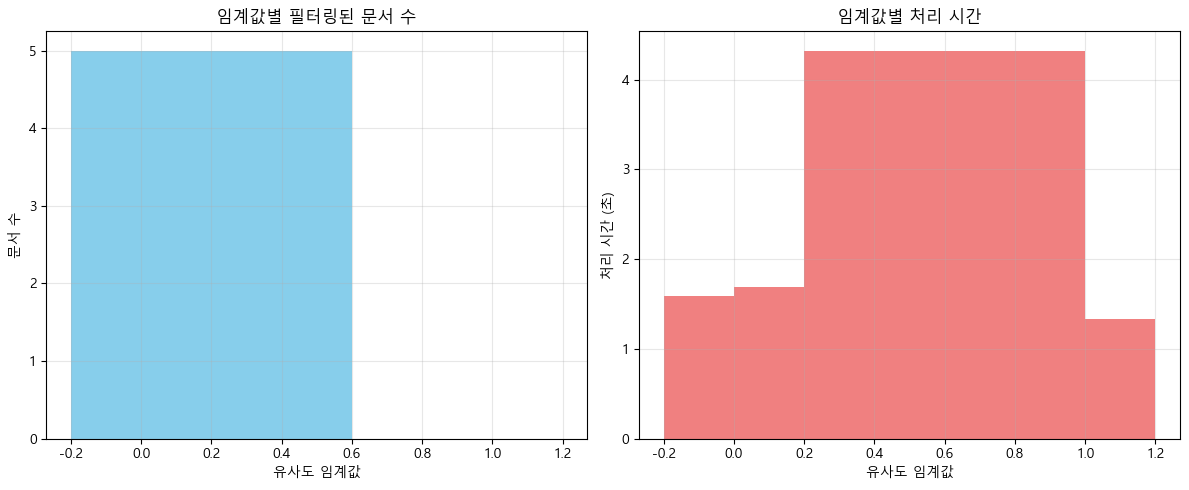

In [22]:
def test_embeddings_filter_thresholds():
    """다양한 임계값에서 임베딩 필터 성능 테스트"""
    if not base_retriever:
        print("❌ 기본 검색기가 초기화되지 않았습니다.")
        return
    
    print("🧮 임베딩 필터 임계값별 성능 테스트")
    print("=" * 80)
    
    # 다양한 임계값 설정
    thresholds = [0.2, 0.4, 0.6, 0.8]
    test_query = "테슬라 트럭 모델이 있나요?"
    
    print(f"테스트 질문: {test_query}\n")
    
    threshold_results = {}
    
    for threshold in thresholds:
        print(f"🔍 임계값 {threshold} 테스트:")
        
        try:
            # 임베딩 필터 생성
            filter_retriever = create_embeddings_filter(
                similarity_threshold=threshold
            )
            
            if filter_retriever:
                start_time = time.time()
                
                # 필터링 실행
                filtered_docs = filter_retriever.invoke(test_query)
                
                end_time = time.time()
                processing_time = end_time - start_time
                
                threshold_results[threshold] = {
                    "filtered_count": len(filtered_docs),
                    "processing_time": processing_time
                }
                
                print(f"   ✅ 필터링된 문서 수: {len(filtered_docs)}개")
                print(f"   ⏱️ 처리 시간: {processing_time:.3f}초")
                
                # 상위 결과 미리보기
                if filtered_docs:
                    print(f"   📄 상위 결과: {filtered_docs[0].page_content[:80]}...")
                else:
                    print("   ❌ 임계값 조건을 만족하는 문서 없음")
            else:
                print("   ❌ 필터 생성 실패")
                
        except Exception as e:
            print(f"   ❌ 오류 발생: {e}")
        
        print("-" * 50)
    
    # 결과 시각화
    if threshold_results:
        print("\n📊 임계값별 결과 요약:")
        
        # DataFrame 생성
        df = pd.DataFrame(threshold_results).T
        df.index.name = 'Threshold'
        df = df.round(3)
        print(df.to_string())
        
        # 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # 필터링된 문서 수
        ax1.bar(df.index, df['filtered_count'], color='skyblue')
        ax1.set_title('임계값별 필터링된 문서 수')
        ax1.set_xlabel('유사도 임계값')
        ax1.set_ylabel('문서 수')
        ax1.grid(True, alpha=0.3)
        
        # 처리 시간
        ax2.bar(df.index, df['processing_time'], color='lightcoral')
        ax2.set_title('임계값별 처리 시간')
        ax2.set_xlabel('유사도 임계값')
        ax2.set_ylabel('처리 시간 (초)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return threshold_results

# 임베딩 필터 임계값 테스트
threshold_test_results = test_embeddings_filter_thresholds()

---

## 5. 파이프라인 최적화 (DocumentCompressorPipeline)

여러 압축 기법을 순차적으로 연결하여 최적의 결과를 얻는 방법입니다.


In [19]:
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter


def create_comprehensive_pipeline():
    """
    포괄적인 문서 압축 파이프라인 생성
    
    Returns:
        ContextualCompressionRetriever: 다단계 압축 검색기
    """
    print("🔧 포괄적인 문서 압축 파이프라인 구성")
    
    try:
        # 임베딩 모델 초기화
        embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        
        # LLM 초기화
        llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
        
        # 파이프라인 구성 요소들
        print("   1️⃣ 중복 제거 필터 추가")
        redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings)
        
        print("   2️⃣ 유사도 기반 필터 추가 (임계값: 0.4)")
        similarity_filter = EmbeddingsFilter(
            embeddings=embeddings, 
            similarity_threshold=0.4
        )
        
        print("   3️⃣ LLM 기반 재순위화 추가")
        llm_reranker = LLMListwiseRerank.from_llm(llm, top_n=5)
        
        # 파이프라인 생성
        pipeline_compressor = DocumentCompressorPipeline(
            transformers=[
                redundant_filter,    # 1단계: 중복 제거
                similarity_filter,   # 2단계: 유사도 필터링
                llm_reranker        # 3단계: LLM 재순위화
            ]
        )
        
        # 최종 압축 검색기 생성
        pipeline_retriever = ContextualCompressionRetriever(
            base_compressor=pipeline_compressor,
            base_retriever=base_retriever,
        )
        
        print("✅ 포괄적인 압축 파이프라인 생성 완료")
        return pipeline_retriever
        
    except Exception as e:
        print(f"❌ 파이프라인 생성 실패: {e}")
        return None

In [20]:
# 파이프라인 생성
pipeline_retriever = create_comprehensive_pipeline()

# 파이프라인 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = pipeline_retriever.invoke(query)

# 검색 결과 출력
print("\n🔄 포괄적인 문서 압축 파이프라인 검색 결과:")
print(f"   필터링된 문서 수: {len(retrieved_docs)}개")
for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)

🔧 포괄적인 문서 압축 파이프라인 구성
   1️⃣ 중복 제거 필터 추가
   2️⃣ 유사도 기반 필터 추가 (임계값: 0.4)
   3️⃣ LLM 기반 재순위화 추가
✅ 포괄적인 압축 파이프라인 생성 완료

🔄 포괄적인 문서 압축 파이프라인 검색 결과:
   필터링된 문서 수: 0개


# 정리



재순위화 / 맥락 압축
> 검색을 하고 끝나는게 아니라, 답변의 퀄리티를 더 향상 시키기 위해서 실행하는 것
> 재순위화 : 관련성 있는 것을 앞으로 배치 (거의 필수적인 작업)
> 맥락 압축 : 불필요 내용 제거


In [ ]:
######## 사전 준비 ########  ::: 백터 저장소 및 기본 검색기 설정

def initialize_vector_store(embeddings = OpenAIEmbeddings(model="text-embedding-3-small"), collection_name="hybrid_search_db", persist_directory = "./local_chroma_db"):
    """
    기존 벡터 저장소를 로드하거나 새로 생성
    
    Returns:
        Chroma: 벡터 저장소 객체
    """
    try:
        
        # 기존 벡터 저장소 로드 시도     
        vector_store = Chroma( 
            collection_name=collection_name, 
            embedding_function=embeddings,
            persist_directory=persist_directory,
        )   
        
        doc_count = vector_store._collection.count() # 저장소 내 문서 개수 확인
        if doc_count > 0:
            print(f"✅ 기존 벡터 저장소 로드: {doc_count}개 문서")
            return vector_store
        else:
            print("⚠️ 빈 벡터 저장소입니다. 데이터를 추가해주세요.")
            return vector_store
            
    except Exception as e:
        print(f"❌ 벡터 저장소 로드 실패: {e}")
        return None

# 벡터 저장소 초기화
vector_store = initialize_vector_store() 

if vector_store:
    # 기본 검색기 생성
    base_retriever = vector_store.as_retriever(search_kwargs={"k": 5}) # 유사도 상위 5개 문서 검색
    print("✅ 기본 검색기 생성 완료")


######## 사전 준비 ########  ::: 평가 데이터셋 로드 및 전처리

def load_evaluation_dataset(file_path):
    """
    평가 데이터셋 로드
    
    Args:
        file_path (str): 평가 데이터 파일 경로
    
    Returns:
        pandas.DataFrame: 평가 데이터셋
    """
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("지원하지 않는 파일 형식")
        
        print(f"✅ 평가 데이터셋 로드: {len(df)}개 질문")
        return df
    except Exception as e:
        print(f"❌ 데이터셋 로드 실패: {e}")
        return None

def prepare_evaluation_data(df):
    """
    평가 데이터 전처리
    
    Args:
        df (pandas.DataFrame): 원본 데이터프레임
    
    Returns:
        tuple: (질문 리스트, 정답 문서 리스트)
    """
    questions = df['user_input'].tolist()
    
    # 정답 문서 파싱
    reference_contexts = []
    for contexts in df['reference_contexts']:
        if isinstance(contexts, str):
            # 문자열을 리스트로 변환
            context_list = eval(contexts)
        else:
            context_list = contexts
        
        # Document 객체로 변환
        docs = [Document(page_content=ctx) for ctx in context_list]
        reference_contexts.append(docs)
    
    return questions, reference_contexts

# 평가 데이터셋 로드
eval_df = load_evaluation_dataset("./data/synthetic_testset.csv")

# 평가 데이터 전처리
questions, reference_contexts = prepare_evaluation_data(eval_df)


In [24]:
######## 재순위화 ########

# 재순위화 시스템 생성

# 1. Cross-Encoder 재순위화 시스템 생성
def create_cross_encoder_reranker(model_name="BAAI/bge-reranker-v2-m3", top_n=5):
    """
    Cross-Encoder 재순위화 시스템 생성
    
    Args:
        model_name (str): 사용할 Cross-Encoder 모델
        top_n (int): 반환할 상위 문서 수
    
    Returns:
        ContextualCompressionRetriever: 재순위화 검색기
    """
    print(f"🔄 Cross-Encoder 재순위화 시스템 초기화")
    print(f"   모델: {model_name}")
    print(f"   상위 {top_n}개 문서 반환")
    
    try:
        # Cross-Encoder 모델 로드
        cross_encoder_model = HuggingFaceCrossEncoder(model_name=model_name)
        
        # 재순위화 컴프레서 생성
        reranker = CrossEncoderReranker(
            model=cross_encoder_model, 
            top_n=top_n
        )
        
        # 컨텍스트 압축 검색기 생성
        compression_retriever = ContextualCompressionRetriever(
            base_compressor=reranker,
            base_retriever=base_retriever,
        )
        
        print("✅ Cross-Encoder 재순위화 시스템 생성 완료")
        return compression_retriever
        
    except Exception as e:
        print(f"❌ Cross-Encoder 초기화 실패: {e}")
        return None
cross_encoder_retriever = create_cross_encoder_reranker(top_n=5)

# CrossEncoderReranker를 사용한 retriever를 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = cross_encoder_retriever.invoke(query) 

# 검색 결과 출력
print("\n🔄 Cross-Encoder 재순위화 검색 결과:")
print("-"*200)

for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)



# 2. LLM 재순위화 시스템 생성
def create_llm_reranker(model_name="gpt-4.1-mini", top_n=5):
    """
    LLM 기반 재순위화 시스템 생성
    
    Args:
        model_name (str): 사용할 LLM 모델
        top_n (int): 반환할 상위 문서 수
    
    Returns:
        ContextualCompressionRetriever: LLM 재순위화 검색기
    """
    print(f"🤖 LLM 재순위화 시스템 초기화")
    print(f"   모델: {model_name}")
    print(f"   상위 {top_n}개 문서 반환")
    
    try:
        # LLM 초기화
        llm = ChatOpenAI(model=model_name, temperature=0)
        
        # LLM 기반 재순위화 컴프레서 생성
        llm_reranker = LLMListwiseRerank.from_llm(llm, top_n=top_n)
        
        # 컨텍스트 압축 검색기 생성
        llm_compression_retriever = ContextualCompressionRetriever(
            base_compressor=llm_reranker,
            base_retriever=base_retriever,
        )
        
        print("✅ LLM 재순위화 시스템 생성 완료")
        return llm_compression_retriever
        
    except Exception as e:
        print(f"❌ LLM 재순위화 초기화 실패: {e}")
        return None
llm_retriever = create_llm_reranker(top_n=3)

# LLM 재순위화 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = llm_retriever.invoke(query)

# 검색 결과 출력
print("\n🤖 LLM 재순위화 검색 결과:")
print("-"*200)

for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)




In [ ]:
# 맥락 압축 


# 3. LLM "필터링" 시스템 생성
def create_llm_filter(model_name="gpt-4.1-mini"):
    """
    LLM 기반 문서 필터링 시스템 생성
    
    Args:
        model_name (str): 사용할 LLM 모델
    
    Returns:
        ContextualCompressionRetriever: LLM 필터링 검색기
    """
    print(f"🔍 LLM 문서 필터링 시스템 초기화")
    print(f"   모델: {model_name}")
    
    try:
        # LLM 초기화
        llm = ChatOpenAI(model=model_name, temperature=0)
        
        # LLM 체인 필터 생성
        llm_filter = LLMChainFilter.from_llm(llm)
        
        # 컨텍스트 압축 검색기 생성
        filter_retriever = ContextualCompressionRetriever(
            base_compressor=llm_filter,
            base_retriever=base_retriever,
        )
        
        print("✅ LLM 필터링 시스템 생성 완료")
        return filter_retriever
        
    except Exception as e:
        print(f"❌ LLM 필터링 초기화 실패: {e}")
        return None
filter_retriever = create_llm_filter()

# LLM 필터링 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = filter_retriever.invoke(query)

# 검색 결과 출력
print("\n🔍 LLM 필터링 검색 결과:")
for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)


# 4. LLM "추출" 시스템 생성
def create_llm_extractor(model_name="gpt-4.1-mini"):
    """
    LLM 기반 정보 *추출* 시스템 생성
    
    Args:
        model_name (str): 사용할 LLM 모델
    
    Returns:
        ContextualCompressionRetriever: LLM 추출 검색기
    """
    print(f"📝 LLM 정보 추출 시스템 초기화")
    print(f"   모델: {model_name}")
    
    try:
        # LLM 초기화
        llm = ChatOpenAI(model=model_name, temperature=0)
        
        # LLM 체인 추출기 생성
        llm_extractor = LLMChainExtractor.from_llm(llm)
        
        # 컨텍스트 압축 검색기 생성
        extractor_retriever = ContextualCompressionRetriever(
            base_compressor=llm_extractor,
            base_retriever=base_retriever,
        )
        
        print("✅ LLM 추출 시스템 생성 완료")
        return extractor_retriever
        
    except Exception as e:
        print(f"❌ LLM 추출 초기화 실패: {e}")
        return None
extractor_retriever = create_llm_extractor()

# LLM 추출 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = extractor_retriever.invoke(query)

# 검색 결과 출력
print("\n📝 LLM 추출 검색 결과:")
for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)



# 5. 임베딩 기반 "필터링" 시스템 생성

def create_embeddings_filter(similarity_threshold=0.1):
    """
    임베딩 기반 유사도 필터링 시스템 생성
    
    Args:
        similarity_threshold (float): 유사도 임계값 (0~1)
    
    Returns:
        ContextualCompressionRetriever: 임베딩 필터링 검색기
    """
    print(f"🧮 임베딩 기반 필터링 시스템 초기화")
    print(f"   유사도 임계값: {similarity_threshold}")
    
    try:
        # 임베딩 모델 초기화
        embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        
        # 임베딩 필터 생성
        embeddings_filter = EmbeddingsFilter(
            embeddings=embeddings, 
            similarity_threshold=similarity_threshold
        )
        
        # 컨텍스트 압축 검색기 생성
        embedding_filter_retriever = ContextualCompressionRetriever(
            base_compressor=embeddings_filter,
            base_retriever=base_retriever,
        )
        
        print("✅ 임베딩 필터링 시스템 생성 완료")
        return embedding_filter_retriever
        
    except Exception as e:
        print(f"❌ 임베딩 필터링 초기화 실패: {e}")
        return None

def test_embeddings_filter_thresholds():
    """다양한 임계값에서 임베딩 필터 성능 테스트"""
    if not base_retriever:
        print("❌ 기본 검색기가 초기화되지 않았습니다.")
        return
    
    print("🧮 임베딩 필터 임계값별 성능 테스트")
    print("=" * 80)
    
    # 다양한 임계값 설정
    thresholds = [0.2, 0.4, 0.6, 0.8]
    test_query = "테슬라 트럭 모델이 있나요?"
    
    print(f"테스트 질문: {test_query}\n")
    
    threshold_results = {}
    
    for threshold in thresholds:
        print(f"🔍 임계값 {threshold} 테스트:")
        
        try:
            # 임베딩 필터 생성
            filter_retriever = create_embeddings_filter(
                similarity_threshold=threshold
            )
            
            if filter_retriever:
                start_time = time.time()
                
                # 필터링 실행
                filtered_docs = filter_retriever.invoke(test_query)
                
                end_time = time.time()
                processing_time = end_time - start_time
                
                threshold_results[threshold] = {
                    "filtered_count": len(filtered_docs),
                    "processing_time": processing_time
                }
                
                print(f"   ✅ 필터링된 문서 수: {len(filtered_docs)}개")
                print(f"   ⏱️ 처리 시간: {processing_time:.3f}초")
                
                # 상위 결과 미리보기
                if filtered_docs:
                    print(f"   📄 상위 결과: {filtered_docs[0].page_content[:80]}...")
                else:
                    print("   ❌ 임계값 조건을 만족하는 문서 없음")
            else:
                print("   ❌ 필터 생성 실패")
                
        except Exception as e:
            print(f"   ❌ 오류 발생: {e}")
        
        print("-" * 50)
    
    # 결과 시각화
    if threshold_results:
        print("\n📊 임계값별 결과 요약:")
        
        # DataFrame 생성
        df = pd.DataFrame(threshold_results).T
        df.index.name = 'Threshold'
        df = df.round(3)
        print(df.to_string())
        
        # 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # 필터링된 문서 수
        ax1.bar(df.index, df['filtered_count'], color='skyblue')
        ax1.set_title('임계값별 필터링된 문서 수')
        ax1.set_xlabel('유사도 임계값')
        ax1.set_ylabel('문서 수')
        ax1.grid(True, alpha=0.3)
        
        # 처리 시간
        ax2.bar(df.index, df['processing_time'], color='lightcoral')
        ax2.set_title('임계값별 처리 시간')
        ax2.set_xlabel('유사도 임계값')
        ax2.set_ylabel('처리 시간 (초)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return threshold_results

# 임베딩 필터 임계값 테스트
threshold_test_results = test_embeddings_filter_thresholds()


In [ ]:
# 6. 포괄적인 문서 압축 파이프라인 생성 (비쌈)


from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter


def create_comprehensive_pipeline():
    """
    포괄적인 문서 압축 파이프라인 생성
    
    Returns:
        ContextualCompressionRetriever: 다단계 압축 검색기
    """
    print("🔧 포괄적인 문서 압축 파이프라인 구성")
    
    try:
        # 임베딩 모델 초기화
        embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        
        # LLM 초기화
        llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
        
        # 파이프라인 구성 요소들
        print("   1️⃣ 중복 제거 필터 추가")
        redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings)
        
        print("   2️⃣ 유사도 기반 필터 추가 (임계값: 0.4)")
        similarity_filter = EmbeddingsFilter(
            embeddings=embeddings, 
            similarity_threshold=0.4
        )
        
        print("   3️⃣ LLM 기반 재순위화 추가")
        llm_reranker = LLMListwiseRerank.from_llm(llm, top_n=5)
        
        # 파이프라인 생성
        pipeline_compressor = DocumentCompressorPipeline(
            transformers=[
                redundant_filter,    # 1단계: 중복 제거
                similarity_filter,   # 2단계: 유사도 필터링
                llm_reranker        # 3단계: LLM 재순위화
            ]
        )
        
        # 최종 압축 검색기 생성
        pipeline_retriever = ContextualCompressionRetriever(
            base_compressor=pipeline_compressor,
            base_retriever=base_retriever,
        )
        
        print("✅ 포괄적인 압축 파이프라인 생성 완료")
        return pipeline_retriever
        
    except Exception as e:
        print(f"❌ 파이프라인 생성 실패: {e}")
        return None
    

# 파이프라인 생성
pipeline_retriever = create_comprehensive_pipeline()

# 파이프라인 검색기 사용하여 검색
query = "테슬라 트럭 모델이 있나요?"
retrieved_docs = pipeline_retriever.invoke(query)

# 검색 결과 출력
print("\n🔄 포괄적인 문서 압축 파이프라인 검색 결과:")
print(f"   필터링된 문서 수: {len(retrieved_docs)}개")
for doc in retrieved_docs:
    print(f"{doc.page_content} [출처: {doc.metadata['source']}]")
    print("="*200)



ranx-k 라이브러리 사용해서 검색 결과 평가


ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가

In [ ]:
##### 각 평가 비교 #####
# base retriever 평가
base_results = evaluate_with_ranx_similarity(
    retriever=base_retriever,
    questions=questions, 
    reference_contexts=reference_contexts,
    k=5,
    method='kiwi_rouge',  
    similarity_threshold=0.8,
)


In [ ]:
# cross-encoder 재순위화 평가
rerank_results = evaluate_with_ranx_similarity(
    retriever=cross_encoder_retriever,
    questions=questions, 
    reference_contexts=reference_contexts,
    k=5,
    method='kiwi_rouge',  
    similarity_threshold=0.8,
)